In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_color_codes()
sns.set(style = 'whitegrid')
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown, display, HTML, display_html

In [2]:
# functions to handle display
def printmd(string, color = None):
    """ setting up customized printing"""
    colorstr = f"<span style = 'color: {color}'>{string}</span>"
    display(Markdown(colorstr))
    
def partioned_display(args):
    """display dataframes side by side"""
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline; margin-left:50px !important:margin-right:40px !important"'), raw = True)

In [3]:
def distplot(figRows, figCols, xSize, ySize, data, features, colors, kde = True, bins = None):
    f, axes = plt.subplots(figRows, figCols, figsize= (xSize, ySize))
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1):
                axesplt = axes
            elif (figRows == 1 and figCols > 1):
                axesplt = axes[col]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)              

In [4]:
def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20)

In [5]:
# load the ratings.csv dataset
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')
movie_ratings = pd.merge(ratings_df, movies_df, left_on = 'movieId', right_on = 'movieId')

In [6]:
movie_ratings.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,9,16,4.0,842686699,Casino (1995),Crime|Drama
2,12,16,1.5,1144396284,Casino (1995),Crime|Drama
3,24,16,4.0,963468757,Casino (1995),Crime|Drama
4,29,16,3.0,836820223,Casino (1995),Crime|Drama


## Exploratory Data Analysis

### a. Drop the 'timestamp' attribute

In [7]:
movie_ratings.drop(['timestamp', 'genres'], axis = 1, inplace = True)

### b. filtering users who has given 50 or more number of rating

In [8]:
movies_groupby_user_rating = movie_ratings.groupby('userId')['rating']
movies_groupby_user_rating = pd.DataFrame(movies_groupby_user_rating.count())

In [9]:
usermin50_ratings = movies_groupby_user_rating[movies_groupby_user_rating['rating'] >= 50].index
movie_ratings = movie_ratings[movie_ratings['userId'].isin(usermin50_ratings)]

In [10]:
# shape of the data
print(f'The total number of rows : {movie_ratings.shape[0]}')
print(f'The total number of columns : {movie_ratings.shape[1]}')

The total number of rows : 97802
The total number of columns : 4


In [11]:
# data type for each attribute
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97802 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   97802 non-null  int64  
 1   movieId  97802 non-null  int64  
 2   rating   97802 non-null  float64
 3   title    97802 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.7+ MB


In [12]:
# checking the presence of missing values
display(movie_ratings.isna().sum().sort_values())
print('===================')
printmd('**CONCLUSION**: As seen from the data above, we conclude there are **"No Missing"** values in the data', color="blue")

userId     0
movieId    0
rating     0
title      0
dtype: int64

<span style = 'color: blue'>**CONCLUSION**: As seen from the data above, we conclude there are **"No Missing"** values in the data</span>

In [13]:
# 5 point summary of numerical attributes
display(movie_ratings[['rating']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
rating,97802.0,3.503246,1.039595,0.5,3.0,3.5,4.0,5.0


In [14]:
# Unique users and movies count
print('Total unique users in the dataset', movie_ratings['userId'].nunique())
print('Total unique movies in the dataset',  movie_ratings['movieId'].nunique())

Total unique users in the dataset 426
Total unique movies in the dataset 10281


## Data Analysis and Visualization

### a. Rating Distribution

In [15]:
pal = sns.color_palette(palette='Set1', n_colors=16)

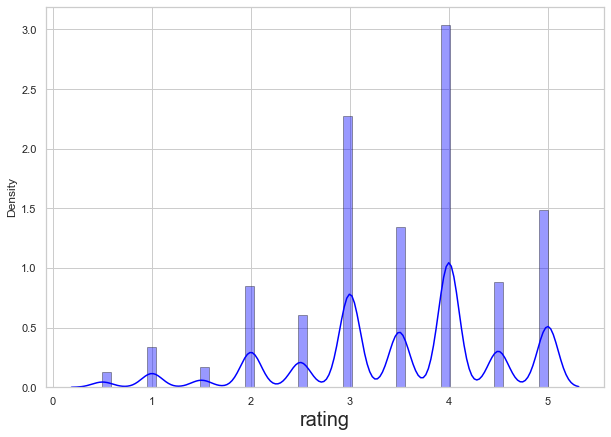

In [16]:
distplot(1, 1, 10, 7, data=movie_ratings, features=['rating'], colors=['blue'])

### Observations
1. Many users have rated 4 as it is displayed by the long bar.
2. This is folowed by rating 3 which has a higher number
3. Ratings 1. 2 are comparatively less

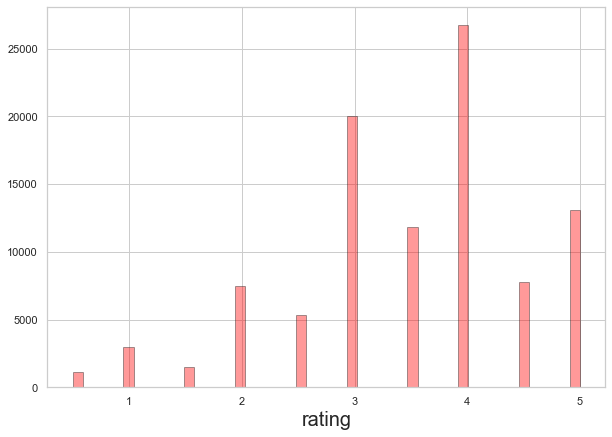

In [17]:
distplot(1, 1, 10, 7, data=movie_ratings, features=['rating'], colors=['red'], kde = False)

### b. Top Rating Count Distribution grouped by Movies

In [18]:
movies_groupby_rating = movie_ratings.groupby('movieId')['rating']
movies_groupby_rating.count().clip(upper = 30).unique()

array([30, 10,  2, 20, 16,  8, 12, 18, 17, 14, 24,  4, 11,  1,  3,  5, 13,
       28, 19, 15,  6,  9, 22,  7, 23, 25, 29, 21, 26, 27], dtype=int64)

In [19]:
ratings_movies = pd.DataFrame(movies_groupby_rating.count().clip(upper=30))
ratings_movies.rename(columns={"rating": "rating_count"}, inplace=True)

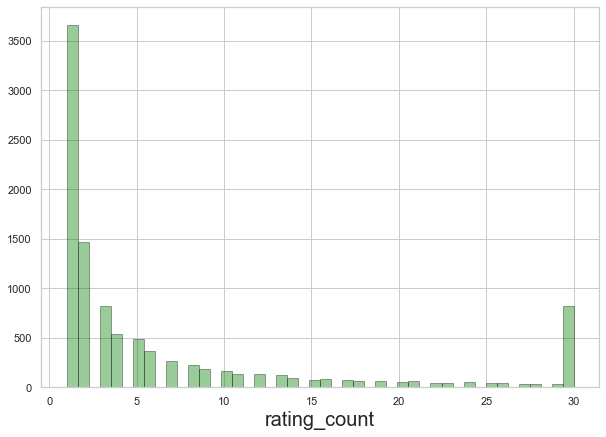

In [20]:
distplot(1, 1, 10, 7, data=ratings_movies, features=['rating_count'], colors=['green'], kde=False)

### c. Top Rating Count Distribution grouped by Users

In [21]:
movies_groupby_user_rating = movie_ratings.groupby('userId')['rating']
movies_groupby_user_rating.count().clip(lower = 50).unique()

array([ 113,   73,  124,   68,   61,  161,   59,  121,   97,   81,  140,
        100,   51,  201,   64,  273,  150,  135,  233,  276,   96,   58,
        365,  103,   66,  207,   65,   88,  120,   54,  223,  202,  158,
       1032, 1107,   53,  353,  380,  175,  148,   60,   74,  147,  272,
        720,  225,  112,   62,   72,  126,  101,  110,   57,  394,  108,
        804,  270,  425,  167,   50,  323,   69,  312,  165,  134, 1231,
        565,   70,  311,  180,  195,   79,  142,  348,  139,  237,   52,
        768,  215,  895,  119,  151,  166,  128,   56,  160,   95,  741,
        550,  155,   99,  275,  238,  721,  414,  122,  123,  268,  159,
        157,  246,   67,   80,  105,  118,  632,  373,  834, 1182,  661,
       1421,  485,  191,  184,  290,  581,  107,  267,  636,   55,   94,
        262,   92,  383,  152,  219,   77,  106,  281,  234,   89,  464,
        266,  197, 1287,  337,  242,  226,  287,   93,  130,  102,   87,
        111,  169,  164,  424,  887,  305,   82,  5

In [22]:
rating_users = pd.DataFrame(movies_groupby_user_rating.count().clip(lower=50, upper=300))
rating_users.rename(columns={"rating": "rating_count"}, inplace=True)

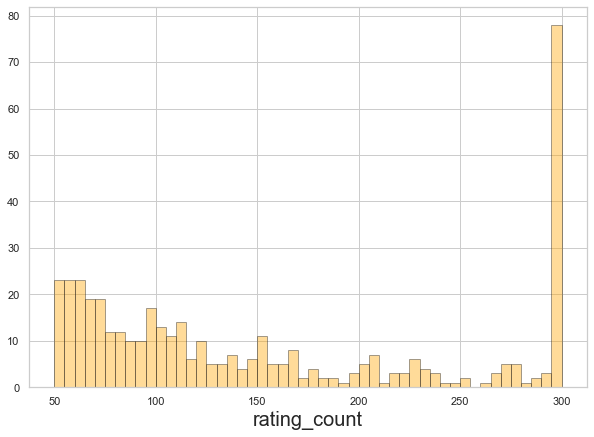

In [23]:
distplot(1, 1, 10, 7, data=rating_users, features=['rating_count'], colors=['orange'], kde=False, bins=50)

### d. Mean Rating distribution grouped by Movies

In [24]:
ratings = pd.DataFrame(movie_ratings.groupby('movieId')['rating'].mean())
ratings.rename(columns={"rating": "rating_mean"}, inplace=True)

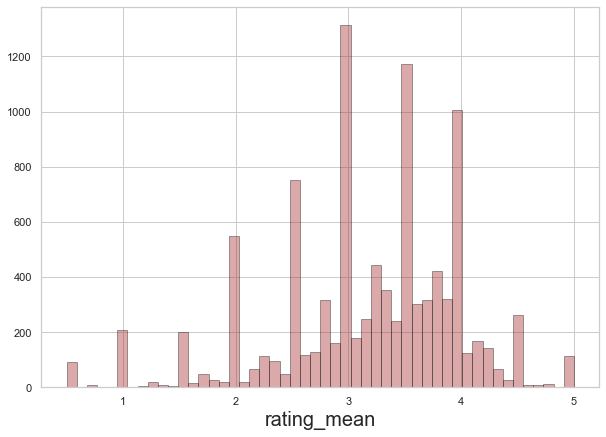

In [25]:
distplot(1, 1, 10, 7, data=ratings, features=['rating_mean'], colors=['brown'], kde=False, bins=50)

### e. Mean Rating - Rating Count Distribution grouped by Products

In [26]:
ratings['rating_count'] = movie_ratings.groupby('movieId')['rating'].count()

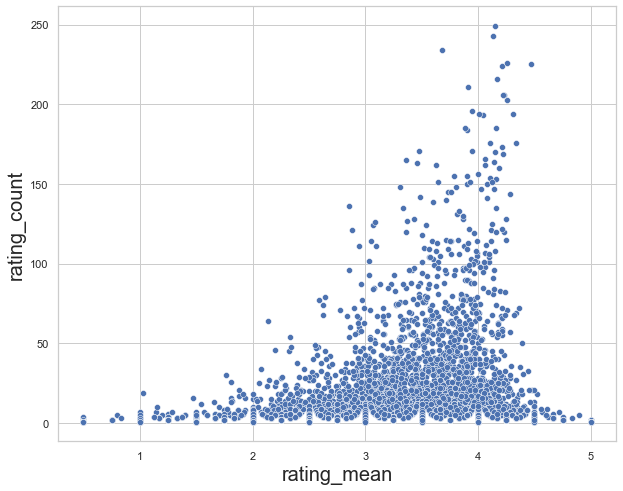

In [27]:
scatterplot('rating_mean', 'rating_count', data=ratings)

### f. Mean Rating Distribution grouped by Users

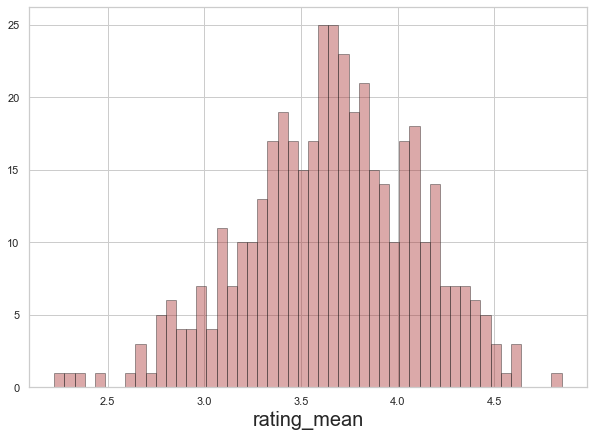

In [28]:
ratings = pd.DataFrame(movie_ratings.groupby('userId')['rating'].mean())
ratings.rename(columns={"rating": "rating_mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['rating_mean'], colors=['brown'], kde=False, bins=50)

### g. Mean Rating - Rating Count Distribution grouped by Users

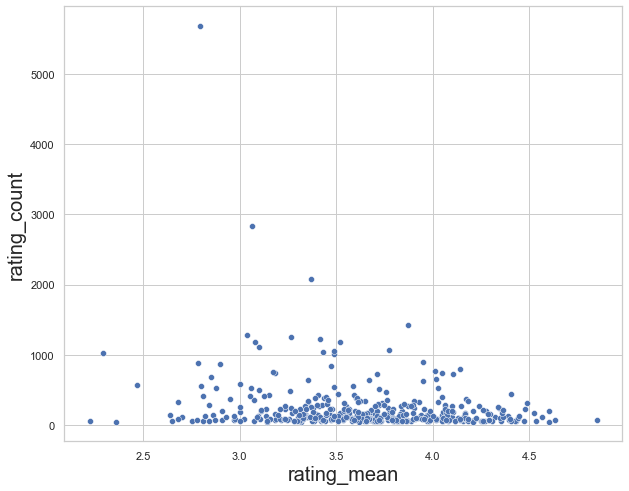

In [29]:
ratings['rating_count'] = movie_ratings.groupby('userId')['rating'].count()
scatterplot('rating_mean', 'rating_count', data=ratings)

# Split data into training and test set in the ratio of 70:30 respectively

In [30]:
train_data, test_data = train_test_split(movie_ratings, test_size =.30, random_state = 10)
printmd('**Training and Testing Set Distribution**', color = 'brown')

print(f'Training set has {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Testing set has {test_data.shape[0]} rows and {test_data.shape[1]} columns')

<span style = 'color: brown'>**Training and Testing Set Distribution**</span>

Training set has 68461 rows and 4 columns
Testing set has 29341 rows and 4 columns


## Recommender Systems

### a. Popularity Based Recommender System

Popularity based recommendation system utilises the items trending currently. The system ranks items based on their popularity, that is the rating count. If an item has high ratings then its very likely that it will be ranked higher and hence will be recommended. The recommendations cannot be personalized as they are based on the popularity of the items, therefore different users might get a recommendation of the same set of items. 

In [31]:
class popularity_based_recommender_model():
    def __init__(self, train_data, test_data, user_id, item_id, title):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.item_id = item_id
        self.title = title
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def fit(self):
        #Get a count of user_ids for each unique product as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
    
        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(20)

    #Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id, n=5):    
        user_recommendations = self.popularity_recommendations
        
        #Filter products that are not rated by the user
        products_already_rated_by_user = self.train_data[self.train_data[self.user_id] == user_id][self.item_id]        
        user_recommendations = user_recommendations[~user_recommendations[self.item_id].isin(products_already_rated_by_user)]
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
        
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols].head(n)     
        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        f, axes = plt.subplots(1, 2, figsize=(20, 8))
        cplot1 = sns.barplot(x='Rank', y='score', data=user_recommendations, hue='Rank', ax=axes[0])
        cplot1.set_xlabel('Rank',fontsize=20)
        cplot1.set_ylabel('score',fontsize=20)
        cplot2 = sns.pointplot(x='Rank', y='score', data=user_recommendations, hue='Rank', ax=axes[1])
        cplot2.set_xlabel('Rank',fontsize=20)
        cplot2.set_ylabel('score',fontsize=20)
        
    def predict_evaluate(self):        
        ratings = pd.DataFrame(self.train_data.groupby(self.item_id)['rating'].mean())
        
        pred_ratings = [];            
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)
        
        mse = mean_squared_error(self.test_data['rating'], pred_ratings)
        rmse = sqrt(mse)
        return rmse

In [32]:
pop_recommender = popularity_based_recommender_model(train_data=train_data, test_data=test_data, user_id='userId', item_id='movieId', title = 'title')

In [33]:
pop_recommender.fit()

,user_id,movieId,score,Rank
251,1,296,196,1.0
1949,1,2571,174,2.0
307,1,356,166,3.0
222,1,260,159,4.0
270,1,318,158,5.0


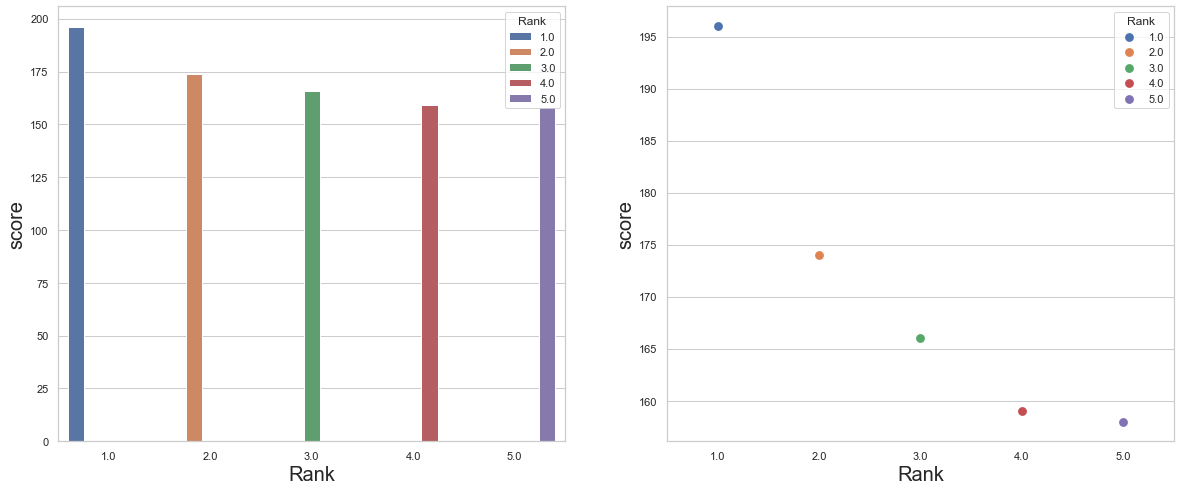

In [85]:
result_pop_user1 = pop_recommender.recommend('1')
result_pop_user1

,user_id,movieId,score,Rank
251,16,296,196,1.0
1949,16,2571,174,2.0
307,16,356,166,3.0
222,16,260,159,4.0
270,16,318,158,5.0


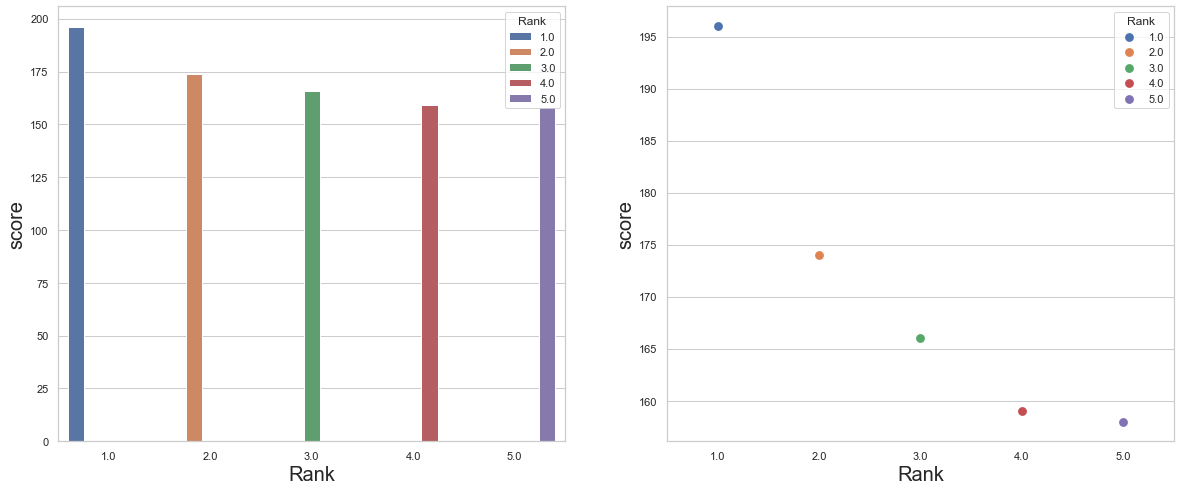

In [35]:
result_pop_user2 = pop_recommender.recommend('16')
result_pop_user2

,user_id,movieId,score,Rank
251,668,296,196,1.0
1949,668,2571,174,2.0
307,668,356,166,3.0
222,668,260,159,4.0
270,668,318,158,5.0


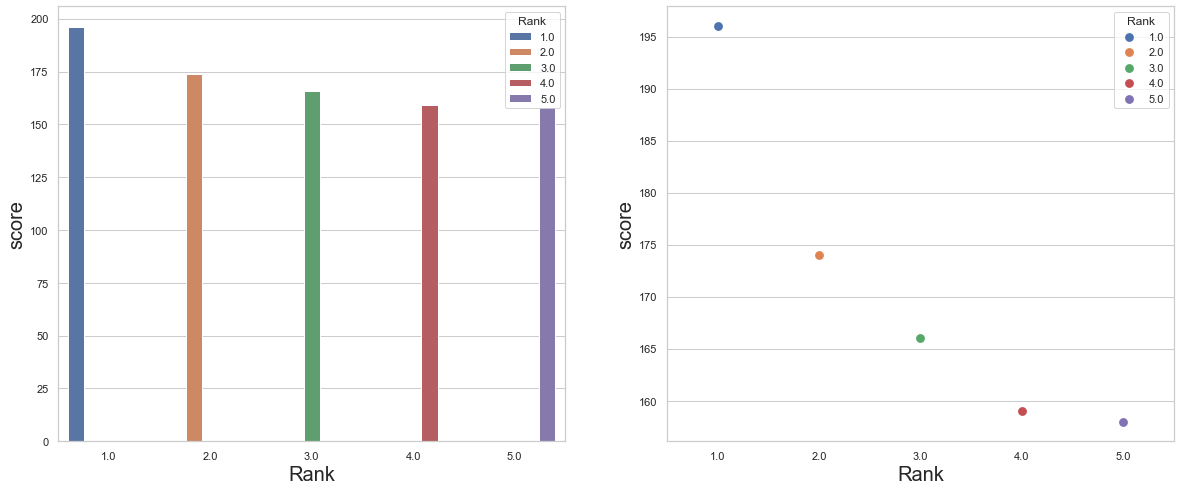

In [36]:
result_pop_user3 = pop_recommender.recommend('668')
result_pop_user3

In [37]:
partioned_display([result_pop_user1, result_pop_user2, result_pop_user3])

,user_id,movieId,score,Rank
251,1,296,196,1.0
1949,1,2571,174,2.0
307,1,356,166,3.0
222,1,260,159,4.0
270,1,318,158,5.0
,user_id,movieId,score,Rank
251,16,296,196,1.0
1949,16,2571,174,2.0
307,16,356,166,3.0
222,16,260,159,4.0


In [38]:
pop_recommender.predict_evaluate()

1.1891939978643358

### Collaborative Filtering Based Recommender System

Collaborative filtering is a method of making predictions about the interests of user by analysing the taste of users which are similar to the in question. The name collaborative filtering stems from the idea of filtering patterns by collaborating multiple viewpoints. 

#### Load Surprise data from DataFrame 

In [39]:
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise import KNNWithMeans
reader = Reader()
movie_ratings.drop('title', axis = 1, inplace = True)
surprise_data = Dataset.load_from_df(movie_ratings, reader)

In [40]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(surprise_data, test_size=.3, random_state=10)

In [41]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [68]:
class collab_filtering_based_recommender_model():
    def __init__(self, model, trainset, testset, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.recommendations = None
        self.top_n = None
        self.recommenddf = None

    def fit_and_predict(self):        
        printmd('**Fitting the train data...**', color='brown')
        self.model.fit(self.trainset)       

        printmd('**Predicting the test data...**', color='brown')
        self.pred_test = self.model.test(self.testset)
        rmse = round(accuracy.rmse(self.pred_test), 3)
        printmd('**RMSE for the predicted result is ' + str(rmse) + '**', color='brown')   
        
        self.top_n = get_top_n(self.pred_test)
        self.recommenddf = pd.DataFrame(columns=['userId', 'movieId', 'rating'])
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns=['movieId', 'rating'])
            subdf['userId'] = item
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]        
            self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)        
        return rmse
        
    def cross_validate(self):
        printmd('**Cross Validating the data...**', color='brown')
        cv_result = cross_validate(self.model, self.data, n_jobs=-1)
        cv_result = round(cv_result['test_rmse'].mean(),3)
        printmd('**Mean CV RMSE is ' + str(cv_result)  + '**', color='brown')
        return cv_result

    def recommend(self, user_id, n=5):
        printmd('**Recommending top ' + str(n)+ ' movies for userid : ' + user_id + ' ...**', color='brown')
        
        #df = pd.DataFrame(self.top_n[user_id], columns=['movieId', 'Rating'])
        #df['UserId'] = user_id
        #cols = df.columns.tolist()
        #cols = cols[-1:] + cols[:-1]
        #df = df[cols].head(n)
        df = self.recommenddf[self.recommenddf['userId'] == user_id].head(n)
        display(df)
        return df
        

### Hyperparameter Optimization - Centered K-Nearest Neighbours

In [69]:
from surprise.model_selection import RandomizedSearchCV

def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

In [70]:
sim_options = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [True],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)

{'rmse': 0.8865974146444918}
{'rmse': {'k': 40, 'sim_options': {'name': 'msd', 'min_support': 4, 'user_based': True}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x00000144D0F5BD48>}


### Model fitting - Centered K-Nearest Neighbours

In [71]:
knnwithmeans = clf.best_estimator['rmse']
col_fil_knnwithmeans = collab_filtering_based_recommender_model(knnwithmeans, trainset, testset, surprise_data)

In [72]:
knnwithmeans_rmse = col_fil_knnwithmeans.fit_and_predict()

<span style = 'color: brown'>**Fitting the train data...**</span>

Computing the msd similarity matrix...
Done computing similarity matrix.


<span style = 'color: brown'>**Predicting the test data...**</span>

RMSE: 0.8871


<span style = 'color: brown'>**RMSE for the predicted result is 0.887**</span>

In [73]:
knnwithmeans_cv_rmse = col_fil_knnwithmeans.cross_validate()

<span style = 'color: brown'>**Cross Validating the data...**</span>

<span style = 'color: brown'>**Mean CV RMSE is 0.887**</span>

In [84]:
result_knn_user1 = col_fil_knnwithmeans.recommend(user_id='1', n=5)
result_knn_user2 = col_fil_knnwithmeans.recommend(user_id='16', n=5)
result_knn_user3 = col_fil_knnwithmeans.recommend(user_id='668', n=5)

<span style = 'color: brown'>**Recommending top 5 movies for userid : 1 ...**</span>

,userId,movieId,rating


<span style = 'color: brown'>**Recommending top 5 movies for userid : 16 ...**</span>

,userId,movieId,rating


<span style = 'color: brown'>**Recommending top 5 movies for userid : 668 ...**</span>

,userId,movieId,rating


### Hyperparameter Optimization - Singular Value Decomposition

In [75]:
params= {
    "n_epochs": [5, 10, 15, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
clf = find_best_model(SVD, params, surprise_data)

{'rmse': 0.8718206784427123}
{'rmse': {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000144D4A8E288>}


### Model fitting - Singular Value Decomposition

In [76]:
svd = clf.best_estimator['rmse']
col_fil_svd = collab_filtering_based_recommender_model(svd, trainset, testset, surprise_data)

In [77]:
svd_rmse = col_fil_svd.fit_and_predict()

<span style = 'color: brown'>**Fitting the train data...**</span>

<span style = 'color: brown'>**Predicting the test data...**</span>

RMSE: 0.8721


<span style = 'color: brown'>**RMSE for the predicted result is 0.872**</span>

In [78]:
svd_cv_rmse = col_fil_svd.cross_validate()

<span style = 'color: brown'>**Cross Validating the data...**</span>

<span style = 'color: brown'>**Mean CV RMSE is 0.872**</span>

In [79]:
result_svd_user1 = col_fil_svd.recommend(user_id='1', n=5)
result_svd_user2 = col_fil_svd.recommend(user_id='16', n=5)
result_svd_user3 = col_fil_svd.recommend(user_id='668', n=5)

<span style = 'color: brown'>**Recommending top 5 movies for userid : 1 ...**</span>

,userId,movieId,rating


<span style = 'color: brown'>**Recommending top 5 movies for userid : 16 ...**</span>

,userId,movieId,rating


<span style = 'color: brown'>**Recommending top 5 movies for userid : 668 ...**</span>

,userId,movieId,rating


### Evaluating Other models on the data

In [86]:
from surprise import NMF
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
benchmark = []
# Iterate over all algorithms
for algorithm in [NMF(), KNNBaseline(), KNNBasic(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, surprise_data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
display(pd.DataFrame(benchmark).set_index('Algorithm').sort_values)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

<bound method DataFrame.sort_values of                test_rmse  fit_time  test_time
Algorithm                                    
NMF             0.914706  7.839883   0.324580
KNNBaseline     0.862985  0.495113   2.013253
KNNBasic        0.948775  0.206338   1.498419
KNNWithZScore   0.884240  0.311507   1.733615
BaselineOnly    0.859827  0.268767   0.139987
CoClustering    0.940671  3.603699   0.151224>

In [81]:
partioned_display([result_knn_user1, result_knn_user2, result_knn_user3])

,userId,movieId,rating
,userId,movieId,rating
,userId,movieId,rating


In [82]:
partioned_display([result_svd_user1, result_svd_user2, result_svd_user3])

,userId,movieId,rating
,userId,movieId,rating
,userId,movieId,rating
